# WEEK 4:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim 
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CLIENT_ID = 'NNO2TDZ2XO2YHCMISLHPTUFBAK0YDZBX3RTF04YY4Q5FVR1W' # your Foursquare ID
CLIENT_SECRET = 'UTNENPNX0IFTQP1VPKXI035AFXQEC5XJCN0XJ5YRMYB05HAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
def clusterCorrelations(corr_matrix, cluster_number, sortby_corr_strength=False):
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(corr_matrix)
    corr_matrix['cluster_labels']=kmeans.labels_
        
    cluster_labels_df=corr_matrix['cluster_labels'].value_counts().to_frame()
    cluster_labels_df=cluster_labels_df.rename(columns={'cluster_labels': 'cluster_size'})
    
    for i in range(0, cluster_number):
        cluster_types=corr_matrix[corr_matrix.cluster_labels==i].index.values.tolist()
        cluster_labels_df.loc[i, 'corr_strength']= np.abs(corr_matrix.loc[cluster_types, cluster_types].mean().mean())
        
    cluster_labels_df['new label']=1
    if sortby_corr_strength:
        cluster_labels_df['new label']=cluster_labels_df.sort_values('corr_strength', ascending=False)['new label'].cumsum()
        cluster_size_list=cluster_labels_df.sort_values('corr_strength', ascending=False).cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']].sort_values('corr_strength', ascending=False))

    else:
        cluster_labels_df['new label']=cluster_labels_df['new label'].cumsum()
        luster_size_list=cluster_labels_df.cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']])
    
    corr_matrix['cluster_labels']=corr_matrix['cluster_labels'].apply(lambda x: cluster_labels_df.loc[x]['new label'])    
    clustered_venues=corr_matrix.sort_values('cluster_labels').index.values.tolist()
    corr_matrix=corr_matrix.loc[clustered_venues, clustered_venues+ ['cluster_labels']]    
        
    for i in range(cluster_number):
        print('\n Cluster {}:'.format(i+1), corr_matrix[corr_matrix.cluster_labels==i+1].index.values.tolist())
        
    fig, (ax1, ax2)=plt.subplots(1,2)
    ax1.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
    ax2.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')    
    
    cluster_line=0
    for cluster_size in cluster_size_list:
        cluster_line+=cluster_size
        ax2.axhline(cluster_line-0.5)
        ax2.axvline(cluster_line-0.5)
    
    plt.show()

### Scrape the Table on the given Wikipedia Page with Beautiful Soup and Display the head of the DataFrame

In [5]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)

In [6]:
soup = BeautifulSoup(page.text, "html.parser")
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df=pd.DataFrame(l, columns=["Postcode", "Borough", "Neighbourhood"])
df=df[df['Borough']!='Not assigned'].dropna()
df['Neighbourhood']=df['Neighbourhood'].str.replace('\n','')

In [7]:
# Group together rows with the same postalcode as required
df=df.groupby(['Postcode', 'Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Fill 'Not- assigned'-values in Neighbourhood-Column with Borough-Name and display the changed rows
na_idx=df[df.Neighbourhood.str.contains('Not assigned')].index
df.loc[na_idx,'Neighbourhood']=df.loc[na_idx,'Borough']

### Filter on Toronto Boroughs only
toronto_df=df[df.Borough.str.contains('Toronto')]

# Load coordinates and merge
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
toronto_df=pd.merge(toronto_df, coordinates, left_on='Postcode', right_on='Postal Code').drop('Postal Code', axis=1)

### Get Venues Nearby

In [8]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### One hot-encoding for the venues

In [9]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

# Cluster Venues bases on Corrleation of their occurences

## Filter on Top Venues only in order to avoid getting high correlations due to single/low-number data points

In [10]:
pd.options.display.max_rows=20
pd.options.display.max_columns=1000

In [11]:
venue_count=toronto_onehot.drop('Neighborhood', axis=1).T.sum(axis=1).to_frame()
venue_count=venue_count.rename(columns={0:'count'})
venue_count=venue_count.sort_values('count', ascending=False)
top_venue_types=venue_count.iloc[0:int(venue_count.shape[0]/4)].index.values.tolist()

In [12]:
toronto_onehot=toronto_onehot[['Neighborhood']+top_venue_types]

# Get Correlation for different vanues based on the data of different neighborhoods

In [13]:
venue_corr=toronto_onehot.groupby(['Neighborhood']).sum().corr()

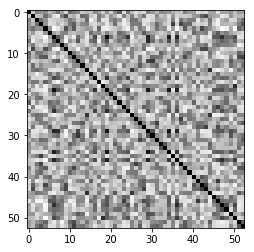

In [14]:
plt.imshow(venue_corr,cmap='Greys',interpolation='nearest')

In [15]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,venue_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)

    # check cluster labelcs generated for each row in the dataframe
    #kmeans.labels_[0:10] 
    scores.append(kmeans.score(venue_corr))

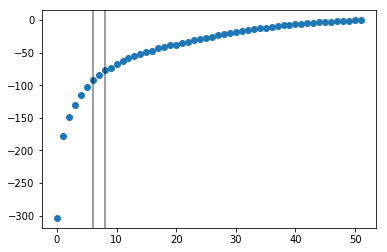

In [16]:
plt.axvline(6, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
2,1,0.470956,14
3,2,0.371863,9
1,3,0.254386,12
0,4,0.252564,18



 Cluster 1: ['Plaza', 'Thai Restaurant', 'Diner', 'Farmers Market', 'Gym', 'Mediterranean Restaurant', 'Comic Shop', 'Theater', 'Concert Hall', 'Japanese Restaurant', 'Hotel', 'Steakhouse', 'Sporting Goods Shop', 'Museum']

 Cluster 2: ['Vietnamese Restaurant', 'Mexican Restaurant', 'Asian Restaurant', 'Yoga Studio', 'Cocktail Bar', 'Brewery', 'Bar', 'Bakery', 'Café']

 Cluster 3: ['American Restaurant', 'Seafood Restaurant', 'Bookstore', 'Beer Bar', 'Art Gallery', 'Dessert Shop', 'Restaurant', 'Sandwich Place', 'Pizza Place', 'Movie Theater', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant']

 Cluster 4: ['Coffee Shop', 'BBQ Joint', 'Liquor Store', 'French Restaurant', 'Spa', 'Grocery Store', 'Pub', 'Breakfast Spot', 'Burger Joint', 'Indian Restaurant', 'Middle Eastern Restaurant', 'Ice Cream Shop', 'Sushi Restaurant', 'Gastropub', 'Italian Restaurant', 'Park', 'Tea Room', 'Trail']


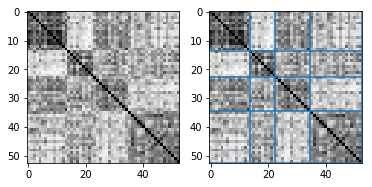

,new label,corr_strength,cluster_size
2,1,0.470956,14
1,2,0.395824,10
3,3,0.387466,8
4,4,0.371863,9
0,5,0.254386,12



 Cluster 1: ['Concert Hall', 'Farmers Market', 'Sporting Goods Shop', 'Diner', 'Theater', 'Plaza', 'Thai Restaurant', 'Gym', 'Steakhouse', 'Mediterranean Restaurant', 'Museum', 'Japanese Restaurant', 'Comic Shop', 'Hotel']

 Cluster 2: ['Park', 'Italian Restaurant', 'Middle Eastern Restaurant', 'Liquor Store', 'Grocery Store', 'Ice Cream Shop', 'Indian Restaurant', 'Spa', 'BBQ Joint', 'French Restaurant']

 Cluster 3: ['Pub', 'Breakfast Spot', 'Tea Room', 'Coffee Shop', 'Trail', 'Burger Joint', 'Gastropub', 'Sushi Restaurant']

 Cluster 4: ['Café', 'Bakery', 'Cocktail Bar', 'Asian Restaurant', 'Yoga Studio', 'Bar', 'Vietnamese Restaurant', 'Brewery', 'Mexican Restaurant']

 Cluster 5: ['Bookstore', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Movie Theater', 'Beer Bar', 'Dessert Shop', 'Sandwich Place']


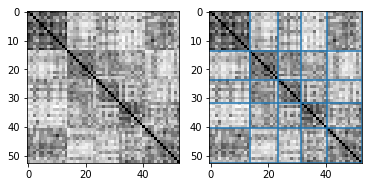

,new label,corr_strength,cluster_size
2,1,0.607382,9
5,2,0.542153,5
1,3,0.395824,10
4,4,0.387466,8
0,5,0.371863,9
3,6,0.254386,12



 Cluster 1: ['Concert Hall', 'Museum', 'Farmers Market', 'Comic Shop', 'Mediterranean Restaurant', 'Hotel', 'Theater', 'Plaza', 'Thai Restaurant']

 Cluster 2: ['Sporting Goods Shop', 'Diner', 'Gym', 'Steakhouse', 'Japanese Restaurant']

 Cluster 3: ['Indian Restaurant', 'Ice Cream Shop', 'Grocery Store', 'Liquor Store', 'BBQ Joint', 'Middle Eastern Restaurant', 'Italian Restaurant', 'Park', 'Spa', 'French Restaurant']

 Cluster 4: ['Tea Room', 'Pub', 'Breakfast Spot', 'Coffee Shop', 'Trail', 'Burger Joint', 'Gastropub', 'Sushi Restaurant']

 Cluster 5: ['Café', 'Bakery', 'Cocktail Bar', 'Asian Restaurant', 'Yoga Studio', 'Bar', 'Vietnamese Restaurant', 'Brewery', 'Mexican Restaurant']

 Cluster 6: ['Bookstore', 'Arts & Crafts Store', 'Vegetarian / Vegan Restaurant', 'American Restaurant', 'Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Movie Theater', 'Beer Bar', 'Dessert Shop', 'Sandwich Place']


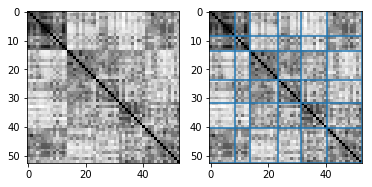

,new label,corr_strength,cluster_size
1,1,0.607382,9
5,2,0.542153,5
0,3,0.526598,6
3,4,0.492884,7
6,5,0.481958,4
4,6,0.395824,10
2,7,0.254386,12



 Cluster 1: ['Museum', 'Comic Shop', 'Mediterranean Restaurant', 'Hotel', 'Farmers Market', 'Theater', 'Plaza', 'Thai Restaurant', 'Concert Hall']

 Cluster 2: ['Steakhouse', 'Sporting Goods Shop', 'Japanese Restaurant', 'Diner', 'Gym']

 Cluster 3: ['Burger Joint', 'Mexican Restaurant', 'Trail', 'Sushi Restaurant', 'Yoga Studio', 'Tea Room']

 Cluster 4: ['Brewery', 'Vietnamese Restaurant', 'Asian Restaurant', 'Bar', 'Cocktail Bar', 'Bakery', 'Café']

 Cluster 5: ['Pub', 'Breakfast Spot', 'Coffee Shop', 'Gastropub']

 Cluster 6: ['Indian Restaurant', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Liquor Store', 'Ice Cream Shop', 'French Restaurant', 'Grocery Store', 'Middle Eastern Restaurant', 'Spa']

 Cluster 7: ['Bookstore', 'Dessert Shop', 'Sandwich Place', 'Vegetarian / Vegan Restaurant', 'Restaurant', 'American Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Movie Theater', 'Beer Bar', 'Arts & Crafts Store']


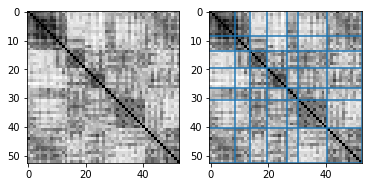

,new label,corr_strength,cluster_size
1,1,0.737872,7
7,2,0.691312,3
5,3,0.526598,6
6,4,0.505084,4
3,5,0.492884,7
0,6,0.481958,4
4,7,0.395824,10
2,8,0.254386,12



 Cluster 1: ['Steakhouse', 'Farmers Market', 'Hotel', 'Theater', 'Plaza', 'Thai Restaurant', 'Concert Hall']

 Cluster 2: ['Museum', 'Comic Shop', 'Mediterranean Restaurant']

 Cluster 3: ['Burger Joint', 'Mexican Restaurant', 'Yoga Studio', 'Trail', 'Sushi Restaurant', 'Tea Room']

 Cluster 4: ['Gym', 'Diner', 'Japanese Restaurant', 'Sporting Goods Shop']

 Cluster 5: ['Asian Restaurant', 'Brewery', 'Bar', 'Cocktail Bar', 'Bakery', 'Café', 'Vietnamese Restaurant']

 Cluster 6: ['Pub', 'Breakfast Spot', 'Coffee Shop', 'Gastropub']

 Cluster 7: ['Indian Restaurant', 'Park', 'Italian Restaurant', 'BBQ Joint', 'Liquor Store', 'Ice Cream Shop', 'French Restaurant', 'Grocery Store', 'Middle Eastern Restaurant', 'Spa']

 Cluster 8: ['Bookstore', 'Dessert Shop', 'Sandwich Place', 'Vegetarian / Vegan Restaurant', 'Restaurant', 'American Restaurant', 'Seafood Restaurant', 'Art Gallery', 'Pizza Place', 'Movie Theater', 'Beer Bar', 'Arts & Crafts Store']


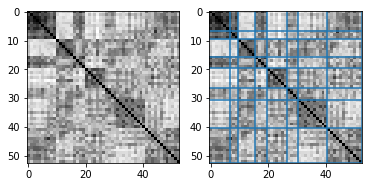

In [17]:
for i in range(4,9):
    clusterCorrelations(venue_corr, i, True)

We find a stable cluster of 11 venues wich are correlated the strongest amongst the set of top venues. 

In [18]:
top_cluster=['Museum', 'Comic Shop', 'Steakhouse', 'Mediterranean Restaurant', 'Hotel', 'Japanese Restaurant', 'Theater', 'Thai Restaurant', 'Plaza', 'Farmers Market', 'Concert Hall']

In [19]:
top_cluster_corr=venue_corr.loc[top_cluster, top_cluster]

We use the corelation amonst the cluster to make a prediction for the number of venues in each neighborhood bases on the other venues

In [20]:
toronto_top_cluster=toronto_onehot[['Neighborhood']+top_cluster].groupby('Neighborhood').sum()

In [21]:
top_cluster_predictions=toronto_top_cluster.copy()

In [22]:
for i in top_cluster:

    get_cluster=top_cluster.copy()
    get_cluster.remove(i)
    prediction=np.dot(np.array(toronto_top_cluster[get_cluster]),top_cluster_corr.loc[get_cluster, i].values.reshape((10,1)))/10

    top_cluster_predictions[[i]]=prediction

In [25]:
business_opportunities=top_cluster_predictions[top_cluster]-toronto_top_cluster

In [26]:
business_opportunities

,Museum,Comic Shop,Steakhouse,Mediterranean Restaurant,Hotel,Japanese Restaurant,Theater,Thai Restaurant,Plaza,Farmers Market,Concert Hall
Neighborhood,,,,,,,,,,,
"Adelaide, King, Richmond",0.079635,-0.212054,-0.493005,0.293252,-3.684512,-1.963568,-1.477969,-0.802465,-0.564122,-0.769006,-0.539085
Berczy Park,0.097341,0.817080,-0.447209,0.300616,-3.613924,-0.915721,-2.492217,-0.754044,-0.505572,-1.754506,-0.495998
"Brockton, Exhibition Place, Parkdale Village",0.322880,0.248881,0.514279,0.395630,-2.747488,-1.746051,-0.553575,-0.662312,0.491565,0.398039,0.462340
Business Reply Mail Processing Centre 969 Eastern,0.154018,-0.932691,0.150250,0.184440,-0.892671,0.112372,0.193772,0.158928,0.151017,-0.899869,0.176465
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",0.522922,0.368440,-0.240899,-0.439422,-3.498917,-1.511528,-0.224064,0.601278,-1.354206,0.615035,0.767927
"Cabbagetown, St. James Town",0.838069,-1.403333,0.170087,-0.026364,-1.949334,-2.234081,-1.918816,-2.133683,0.113107,-0.033207,0.141383
Central Bay Street,-0.088037,-0.332225,-0.761059,0.083365,-1.817890,-2.145668,-1.805079,0.019003,0.239086,0.036273,-1.872094
"Chinatown, Grange Park, Kensington Market",0.332453,0.263725,-0.584272,-0.665362,-0.575590,-0.684459,-0.567301,-0.674189,0.471294,0.395422,-0.590724
Christie,-0.906916,0.104605,0.168263,0.156330,0.180249,-0.933951,0.169039,0.132982,0.139851,-0.918333,0.170504


Museum


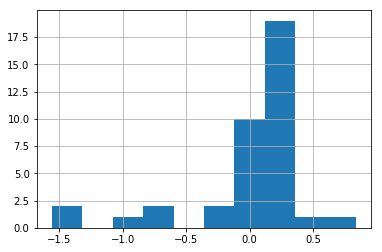

Comic Shop


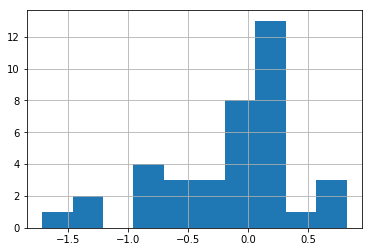

Steakhouse


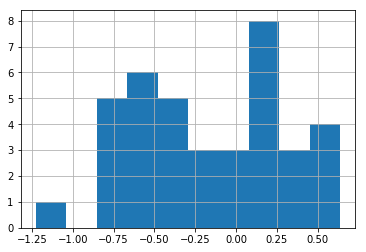

Mediterranean Restaurant


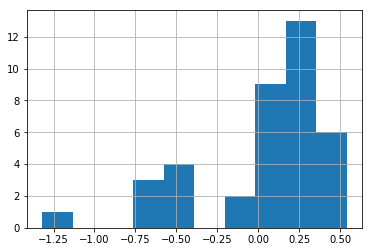

Hotel


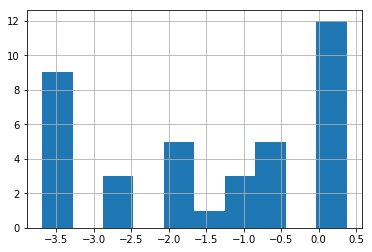

Japanese Restaurant


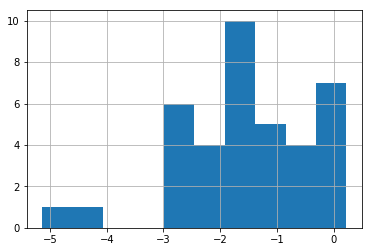

Theater


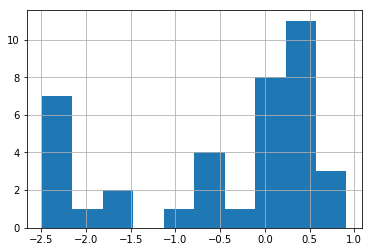

Thai Restaurant


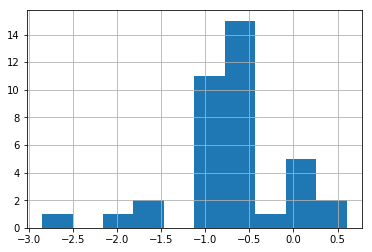

Plaza


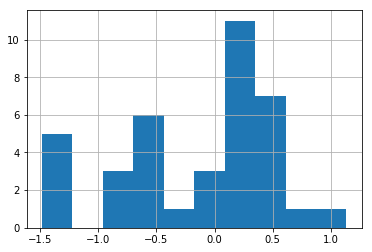

Farmers Market


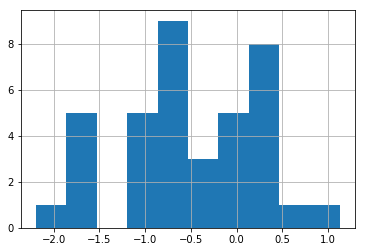

Concert Hall


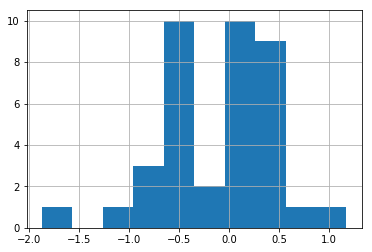

In [42]:
for venue in top_cluster:
    print(venue)
    (business_opportunities[venue]).hist()
    plt.show()

In [ ]:
for row in business_opportunities.shape()